# 02. Alternating Least Squares for Factorization Machine

In [1]:
import numpy as np
from typing import Optional

## Factorization Machine as a Linear Model

As we noted in FM_01_linear.ipynb, an FM can be rewritten as a linear model. The FM model is defined as

$$
\begin{aligned}

f(x; b, w, v)
&= b + \sum_{i=1}^N w_i x_i + \sum_{i \lt j} \sum_{k=1}^K v_{ik} v_{jk} x_i x_j \\

&= \theta h_\theta(x) + g_\theta(x)

\end{aligned}
$$

where

$$
\begin{aligned}
h_\theta(x) &\coloneqq
\left\{\begin{aligned}
    & 1,
    && \theta=b \\
    & x_i,
    && \theta=w_i\\
    & x_i \left( \sum_{j=1}^N v_{jk} x_j - v_{ik} x_i \right),
    && \theta = v_{ik}
\end{aligned}\right.
\\

g_\theta(x) &\coloneqq f(x) - \theta h_\theta(x).
\end{aligned}
$$

In [2]:
class FactorizationMachines:
    def __init__(self,
        num_features: int,
        num_factors:  int,
        sigma_b_init: float=0.,
        sigma_w_init: float=1.,
        sigma_v_init: float=1.,
        seed: Optional[int]=None
    ) -> None:
        self.rng = np.random.default_rng(seed)
        b = self.rng.normal(0, sigma_b_init)
        w = self.rng.normal(0, sigma_w_init, num_features)
        v = self.rng.normal(0, sigma_v_init, (num_features, num_factors))
        self.params = {'b': b, 'w': w, 'v': v}

    def predict(self, x: np.ndarray) -> float:
        if x.ndim == 1:
            x = x.reshape(1, -1) # x: (d, n)
        b = self.params['b']     # b: (1)
        w = self.params['w']     # w: (d)
        v = self.params['v']     # v: (d, k)

        bias   = b
            # (1)
        linear = x[:, :] @ w[:]
            # (D, N) @ (N) = (D)
        inter  = 0.5 * np.sum((x[:, :] @ v[:, :]) ** 2 - (x[:, :] ** 2) @ (v[:, :] ** 2), axis=1)
            # (D, K) -> (D)

        result = bias + linear + inter
            # (D)

        if result.shape[0] == 1:
            return float(result[0])
        return result

We can speed up the computation of $h_\theta$ and $g_\theta$ by precomputation and updating techniques.

$$
\begin{aligned}
q_k^{(d)}
&=
\sum_{j=1}^N v_{jk} x_j^{(d)},
\\

\Delta f^{(d)}
&= (\theta^{\rm new} - \theta) h_\theta^{(d)},
\\

\Delta q_k^{(d)}
&= x_i^{(d)} (v_{ik}^{\rm new} - v_{ik}),
\\

h_\theta^{(d)}
&=
\left\{\begin{aligned}
& 1,
&& \theta=b \\
& x_i^{(d)},
&& \theta=w_i\\
& x_i^{(d)} \left( q_k^{(d)} - v_{ik} x_i^{(d)} \right).
&& \theta = v_{ik}
\end{aligned}\right.
\end{aligned}
$$

The time complexity is $\mathcal O(1)$ for every $\theta$.

In [3]:
def calc_q_init(x: np.ndarray, v: np.ndarray) -> np.ndarray:
    # x: (D, N)
    # v: (N, K)
    return x[:, :] @ v[:, :] # (D, K)

def calc_dq(x: np.ndarray, v_ik_new: float, v: np.ndarray, i: int, k: int) -> np.ndarray:
    # v_ik_new: float
    # v: (N, K)
    # x: (D, N)
    return (v_ik_new - v[i, k]) * x[:, i] # (D)

def calc_df(h: np.ndarray, p_new: float, p_old: float) -> np.ndarray:
    # h: (D)
    return (p_new - p_old) * h # (D)

def calc_h_b(x) -> float:
    return np.ones(x.shape[0])

def calc_h_w(x: np.ndarray, i: int) -> np.ndarray:
    # x: (D, N)
    return x[:, i]

def calc_h_v_fast(x: np.ndarray, v: np.ndarray, q: np.ndarray, i: int, k: int) -> np.ndarray:
    # x: (D, N)
    # v: (N, K)
    # q: (D, K)
    return x[:, i] * (q[:, k] - x[:, i] * v[i, k]) # (D)

def calc_g(f: np.ndarray, h: np.ndarray, p: float) -> np.ndarray:
    g = f - h * p
    return g

## Alternating Least Squares (ALS) for Factorization Machines

Assume that a model is first-order for each parameter $\theta \in \Theta$ and can be written as

$$
    y_\theta^{(d)} = \theta x_\theta^{(d)} + \varepsilon^{(d)},
$$

where
- $y_\theta^{(d)}$ is the output variable,
- $x_\theta^{(d)}$ is the input variable,
- $\theta$ is the model parameter, and
- $\varepsilon^{(d)}$ is the error term.

We want to estimate $\theta$ from the observed data $\{x_\theta^{(d)}, y_\theta^{(d)}\}_{d=1}^D$.

## Ordinary Least Squares (OLS)

If a model has a single parameter, $\Theta = \{ \theta \}$, we can estimate $\theta$ by minimizing the sum of squared errors (SSE):

$$
\begin{aligned}
\hat \theta
&= \argmin_\theta \sum_{d=1}^D \left( y_\theta^{(d)} - \theta x_\theta^{(d)} \right)^2,
\end{aligned}
$$

whose result is given by

$$
\begin{aligned}
\hat \theta
&= (x_\theta^\top x_\theta)^{-1} x_\theta^\top y_\theta \\
&= \left( \sum_{d=1}^D x_\theta^{(d)2} \right)^{-1} \sum_{d=1}^D x_\theta^{(d)} y_\theta^{(d)}.
\end{aligned}
$$

This is called the **ordinary least squares** (OLS) method.

## Alternating Least Squares (ALS)

On the other hand, if we have an $M$-parameter models, i.e., $\Theta = \{ \theta_m \}_{m=1,\dots,M}$, and the model is first-order with respect to each $\theta_m$, we *alternatively* apply the least squares method to each parameter $\theta_m$:

1. repeat until convergence:
   1. repeat for all $\theta_m \in \Theta$:
      1. fix all the other parameters $\Theta \setminus \{\theta_m\}$
      2. estimate $\theta_m$ by minimizing the SSE

For example, let our model given by

$$
\begin{aligned}
y^{(d)}
&= f^{(d)} + \varepsilon^{(d)},
\end{aligned}
$$

where

$$
\begin{aligned}
f^{(d)} = \sum_{i=1}^N \sum_{j=1}^N \sum_{k=1}^K v_{ik} v_{jk} x_i^{(d)} x_j^{(d)}.
\end{aligned}
$$

The model has $NK$ parameters $\Theta = \{ v_{ik} \}_{(i,k) \in [N] \times [K]}$ and first-order with respect to each parameter.

We can estimate $v_{ik}$ by minimizing the SSE:

$$
\begin{aligned}
\hat v_{ik}
&= \argmin_{v_{ik}} \sum_{d=1}^D \left( y^{(d)} - \sum_{i=1}^N \sum_{j=1}^N \sum_{k=1}^K v_{ik} v_{jk} x_i^{(d)} x_j^{(d)} \right)^2.
\end{aligned}
$$

If we write

$$
\begin{aligned}
x_{v_{ik}}^{(d)}
&\coloneqq
\frac{\partial f^{(d)}}{\partial v_{ik}},
\\

g_{v_{ik}}^{(d)}
&\coloneqq
f^{(d)} - v_{ik} h_{v_{ik}}^{(d)},
\\

y_{v_{ik}}^{(d)}
&\coloneqq
y^{(d)} - g_{v_{ik}}^{(d)},
\end{aligned}
$$

the estimator of $v_{ik}$ is given by

$$
\begin{aligned}
\hat v_{ik}
&=
\argmin_{v_{ik}} \sum_{d=1}^D \left( y^{(d)} - (v_{ik} x_{v_{ik}}^{(d)} + g_{v_{ik}}^{(d)}) \right)^2
\\

&=
\argmin_{v_{ik}} \sum_{d=1}^D \left( (y^{(d)} - g_{v_{ik}}^{(d)}) - v_{ik} x_{v_{ik}}^{(d)} \right)^2
\\

&=
\argmin_{v_{ik}} \sum_{d=1}^D \left( y_{v_{ik}}^{(d)} - v_{ik} x_{v_{ik}}^{(d)} \right)^2
\\

&=
\left( \sum_{d=1}^D x_{v_{ik}}^{(d)2} \right)^{-1} \sum_{d=1}^D x_{v_{ik}}^{(d)} y_{v_ik}^{(d)}.
\end{aligned}
$$

This is how the **alternating least squares (ALS)** method works.

## ALS for FM

From here, we apply the ALS method to the FM.

Again, the model of an FM is given by

$$
\begin{aligned}
f^{(d)} = \theta h_\theta^{(d)} + g_\theta^{(d)}.
\end{aligned}
$$

By defining

$$
\begin{aligned}
x_\theta^{(d)} &\coloneqq h_\theta^{(d)}, \\
y_\theta^{(d)} &\coloneqq y^{(d)} - g_\theta^{(d)},
\end{aligned}
$$

the estimated $\theta$ is

$$
\begin{aligned}
\hat \theta

&=
\left( \sum_{d=1}^D x_\theta^{(d)2} \right)^{-1} \sum_{d=1}^D x_\theta^{(d)} y_\theta^{(d)}.
\end{aligned}
$$

By repeating this for all $\theta \in \Theta$, we can estimate the parameters of the FM.

Since the use of naive OLS may result in division by zero, it is common to use L2 regularization as an alternative:

$$
\begin{aligned}
\hat \theta

&=
\left( \sum_{d=1}^D x_\theta^{(d)2} + \lambda \right)^{-1} \sum_{d=1}^D x_\theta^{(d)} y_\theta^{(d)}.
\end{aligned}
$$

In [4]:
def calc_q_init(x: np.ndarray, v: np.ndarray) -> np.ndarray:
    # x: (D, N)
    # v: (N, K)
    return x[:, :] @ v[:, :] # (D, K)

def calc_dq(x: np.ndarray, v_ik_new: float, v: np.ndarray, i: int, k: int) -> np.ndarray:
    # v_ik_new: float
    # v: (N, K)
    # x: (D, N)
    return (v_ik_new - v[i, k]) * x[:, i] # (D)

def calc_df(h: np.ndarray, p_new: float, p_old: float) -> np.ndarray:
    # h: (D)
    return (p_new - p_old) * h # (D)

def calc_h_b(x) -> float:
    return np.ones(x.shape[0])

def calc_h_w(x: np.ndarray, i: int) -> np.ndarray:
    # x: (D, N)
    return x[:, i]

def calc_h_v_fast(x: np.ndarray, v: np.ndarray, q: np.ndarray, i: int, k: int) -> np.ndarray:
    # x: (D, N)
    # v: (N, K)
    # q: (D, K)
    return x[:, i] * (q[:, k] - x[:, i] * v[i, k]) # (D)

def calc_g(f: np.ndarray, h: np.ndarray, p: float) -> np.ndarray:
    g = f - h * p
    return g

def sample_param_lstsq(y: np.ndarray, h: np.ndarray, g: np.ndarray, lamb: float=1e-8) -> float:
    # h: (D)
    # g: (D)
    x_theta = h
    y_theta = y - g
    return np.sum(x_theta * y_theta) / (np.sum(x_theta ** 2) + lamb)

def train_fm_als(
    init_params: dict,
    x_data: np.ndarray,
    y_data: np.ndarray,
    f_init: np.ndarray,
    num_iter: int,
) -> dict:
    # get indices
    N = x_data.shape[1]
    K = init_params['v'].shape[1]

    # get initial parameter
    params = init_params

    # precalculate
    f = f_init
    q = calc_q_init(x_data, params['v'])

    # main loop
    for iter in range(num_iter):
        # sample b
        h_b   = calc_h_b(x_data)
        g_b   = calc_g(f, h_b, params['b'])
        b_new = sample_param_lstsq(y_data, h_b, g_b)
        f     = f + calc_df(h_b, b_new, params['b'])
        params['b'] = b_new

        # sample w
        for i in range(N):
            h_w   = calc_h_w(x_data, i)
            g_w   = calc_g(f, h_w, params['w'][i])
            w_i_new = sample_param_lstsq(y_data, h_w, g_w)
            f     = f + calc_df(h_w, w_i_new, params['w'][i])
            params['w'][i] = w_i_new

        # sample v
        for i in range(N):
            for k in range(K):
                h_v      = calc_h_v_fast(x_data, params['v'], q, i, k)
                g_v      = calc_g(f, h_v, params['v'][i, k])
                v_ik_new = sample_param_lstsq(y_data, h_v, g_v)
                f        = f      + calc_df(h_v, v_ik_new, params['v'][i, k])
                q[:,k]   = q[:,k] + calc_dq(x_data, v_ik_new, params['v'], i, k)
                params['v'][i, k] = v_ik_new

        if iter % 10 == 0:
            print(f'iter: {iter}, loss: {np.mean((y_data - f) ** 2)}')

    return params

In [5]:
# test
N = 16
K = 8
D = 128

seed = 0
rng  = np.random.default_rng(seed)
fm   = FactorizationMachines(N, K, seed=seed)
x    = rng.choice((0, 1), size=(D, N))

Q    = rng.uniform(-1., 1., (N, N))
y    = np.einsum('dn,nm,dm->d', x, Q, x)

_ = train_fm_als(
    fm.params, x, y, fm.predict(x), 1000
)

iter: 0, loss: 26.39329176790396
iter: 10, loss: 2.3858678729327116
iter: 20, loss: 1.2735758696485489
iter: 30, loss: 0.877355504778103
iter: 40, loss: 0.585963714328617
iter: 50, loss: 0.3821961192027613
iter: 60, loss: 0.31346318080660984
iter: 70, loss: 0.2759510632942438


iter: 80, loss: 0.2478740205126534
iter: 90, loss: 0.22491829439837246
iter: 100, loss: 0.205683520927063
iter: 110, loss: 0.18932825865828948
iter: 120, loss: 0.17523883467637943
iter: 130, loss: 0.16298095072785646
iter: 140, loss: 0.1522543744330969
iter: 150, loss: 0.14284317842872335
iter: 160, loss: 0.13457849180403977
iter: 170, loss: 0.12731826095125778
iter: 180, loss: 0.12093892161998704
iter: 190, loss: 0.11533219933686281
iter: 200, loss: 0.11040298662542901
iter: 210, loss: 0.10606716544653094
iter: 220, loss: 0.10224961083738565
iter: 230, loss: 0.09888274071974543
iter: 240, loss: 0.09590567739768235
iter: 250, loss: 0.09326384701702065
iter: 260, loss: 0.09090878000112879
iter: 270, loss: 0.08879792819306101
iter: 280, loss: 0.08689440045664532
iter: 290, loss: 0.085166589623591
iter: 300, loss: 0.08358770613351095
iter: 310, loss: 0.08213525175345
iter: 320, loss: 0.08079046949114813
iter: 330, loss: 0.0795378009635657
iter: 340, loss: 0.07836437491224528
iter: 350, lo

Seems pretty good. Let's implement above in Julia to make it superfast!

In [67]:
from julia import Main

julia_code = """
function calc_q_init(x::Array{Int64,2}, v::Array{Float64,2})::Array{Float64,2}
    # x: (D, N)
    # v: (N, K)
    return x[:, :] * v[:, :] # (D, K)
end

function calc_dq(x::Array{Int64,2}, v_ik_new::Float64, v::Array{Float64,2}, i::Int, k::Int)::Array{Float64,1}
    # v_ik_new: float
    # v: (N, K)
    # x: (D, N)
    return (v_ik_new - v[i, k]) * x[:, i] # (D)
end

function calc_df(h::Array{Float64,1}, p_new::Float64, p_old::Float64)::Array{Float64,1}
    # h: (D)
    return (p_new - p_old) * h # (D)
end

function calc_h_b(x::Array{Int64,2})::Array{Float64,1}
    return ones(size(x, 1))
end

function calc_h_w(x::Array{Int64,2}, i::Int)::Array{Float64,1}
    # x: (D, N)
    return x[:, i]
end

function calc_h_v_fast(x::Array{Int64,2}, v::Array{Float64,2}, q::Array{Float64,2}, i::Int, k::Int)::Array{Float64,1}
    # x: (D, N)
    # v: (N, K)
    # q: (D, K)
    return x[:, i] .* (q[:, k] - x[:, i] .* v[i, k]) # (D)
end

function calc_g(f::Array{Float64,1}, h::Array{Float64,1}, p::Float64)::Array{Float64,1}
    g = f - h .* p
    return g
end

function sample_param_lstsq(y::Array{Float64,1}, h::Array{Float64,1}, g::Array{Float64,1}, lamb::Float64=1e-8)::Float64
    # h: (D)
    # g: (D)
    x_theta = h
    y_theta = y - g
    return sum(x_theta .* y_theta) / (sum(x_theta .^ 2) + lamb)
end

function train_fm_als(
    init_params::Dict,
    x_data::Array{Int64,2},
    y_data::Array{Float64,1},
    f_init::Array{Float64,1},
    num_iter::Int
)::Tuple{Dict, Array{Float64,1}}
    # loss history
    loss_hist = Float64[]
    push!(loss_hist, sum((y_data - f_init) .^ 2) / size(y_data, 1))

    # get indices
    N = size(x_data, 2)
    K = size(init_params["v"], 2)

    # get initial parameter
    params = init_params

    # precalculate
    f = f_init
    q = calc_q_init(x_data, params["v"])

    # main loop
    for iter in 1:num_iter
        # sample b
        h_b   = calc_h_b(x_data)
        g_b   = calc_g(f, h_b, params["b"])
        b_new = sample_param_lstsq(y_data, h_b, g_b)
        f     = f + calc_df(h_b, b_new, params["b"])
        params["b"] = b_new

        # sample w
        for i in 1:N
            h_w   = calc_h_w(x_data, i)
            g_w   = calc_g(f, h_w, params["w"][i])
            w_i_new = sample_param_lstsq(y_data, h_w, g_w)
            f     = f + calc_df(h_w, w_i_new, params["w"][i])
            params["w"][i] = w_i_new
        end

        # sample v
        for i in 1:N
            for k in 1:K
                h_v      = calc_h_v_fast(x_data, params["v"], q, i, k)
                g_v      = calc_g(f, h_v, params["v"][i, k])
                v_ik_new = sample_param_lstsq(y_data, h_v, g_v)
                f        = f      + calc_df(h_v, v_ik_new, params["v"][i, k])
                q[:,k]   = q[:,k] + calc_dq(x_data, v_ik_new, params["v"], i, k)
                params["v"][i, k] = v_ik_new
            end
        end

        if iter % 10 == 0
            println("iter: $iter, loss: $(sum((y_data - f) .^ 2) / size(y_data, 1))")
        end

        push!(loss_hist, sum((y_data - f) .^ 2) / size(y_data, 1))
    end

    return params, loss_hist
end
"""

Main.eval(julia_code)

<PyCall.jlwrap train_fm_als>

In [88]:
# test
N = 16
K = 8
D = 128

seed = 0
rng  = np.random.default_rng(seed)
fm   = FactorizationMachines(N, K, seed=seed)
x    = rng.choice((0, 1), size=(D, N))

Q    = rng.uniform(-1., 1., (N, N))
y    = np.einsum('dn,nm,dm->d', x, Q, x)

_, loss_hist = Main.train_fm_als(
    fm.params, x, y, fm.predict(x), 10000
)

iter: 10, loss: 2.6647681411167468
iter: 20, loss: 1.32934990271368
iter: 30, loss: 0.9091061582182377
iter: 40, loss: 0.6147971031641509
iter: 50, loss: 0.39377628835964895
iter: 60, loss: 0.31820225501498256
iter: 70, loss: 0.27914843037945875
iter: 80, loss: 0.2504179447407509
iter: 90, loss: 0.22702999530023021
iter: 100, loss: 0.20746555786830556
iter: 110, loss: 0.19085322387488063
iter: 120, loss: 0.1765594138540084
iter: 130, loss: 0.16413368938025383
iter: 140, loss: 0.15326474004443702
iter: 150, loss: 0.14373017132132043
iter: 160, loss: 0.135357576095628
iter: 170, loss: 0.12800273211593904
iter: 180, loss: 0.12154041146253809
iter: 190, loss: 0.11586090770753783
iter: 200, loss: 0.11086789368331386
iter: 210, loss: 0.1064762488603552
iter: 220, loss: 0.10261002483105713
iter: 230, loss: 0.09920093218900786
iter: 240, loss: 0.09618744615122982
iter: 250, loss: 0.09351437305598995
iter: 260, loss: 0.09113264035387658
iter: 270, loss: 0.088999117896592
iter: 280, loss: 0.0870

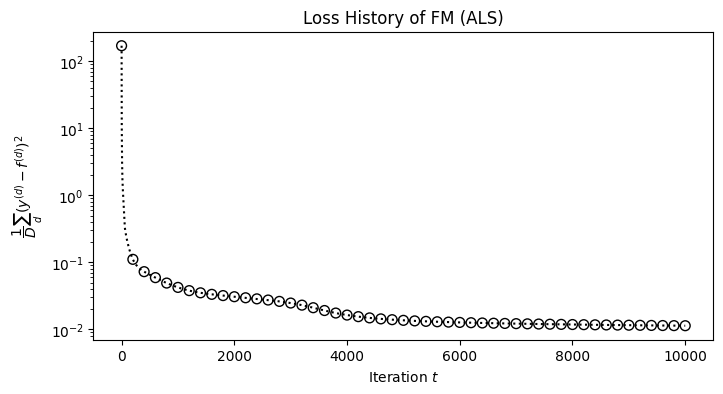

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.scatter(range(len(loss_hist))[::200], loss_hist[::200], s=50, marker='o', color='none', edgecolors='black')
plt.plot(loss_hist, color='black', linestyle='dotted')
plt.yscale('log')
plt.xlabel(r'Iteration $t$')
plt.ylabel(r'$\dfrac{1}{D} \sum_{d} (y^{(d)} - f^{(d)})^2$')
plt.title('Loss History of FM (ALS)')
plt.show()